/tmp/ipython-input-451831630.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_offences, y="Suburb", x="Offence count", palette="viridis")


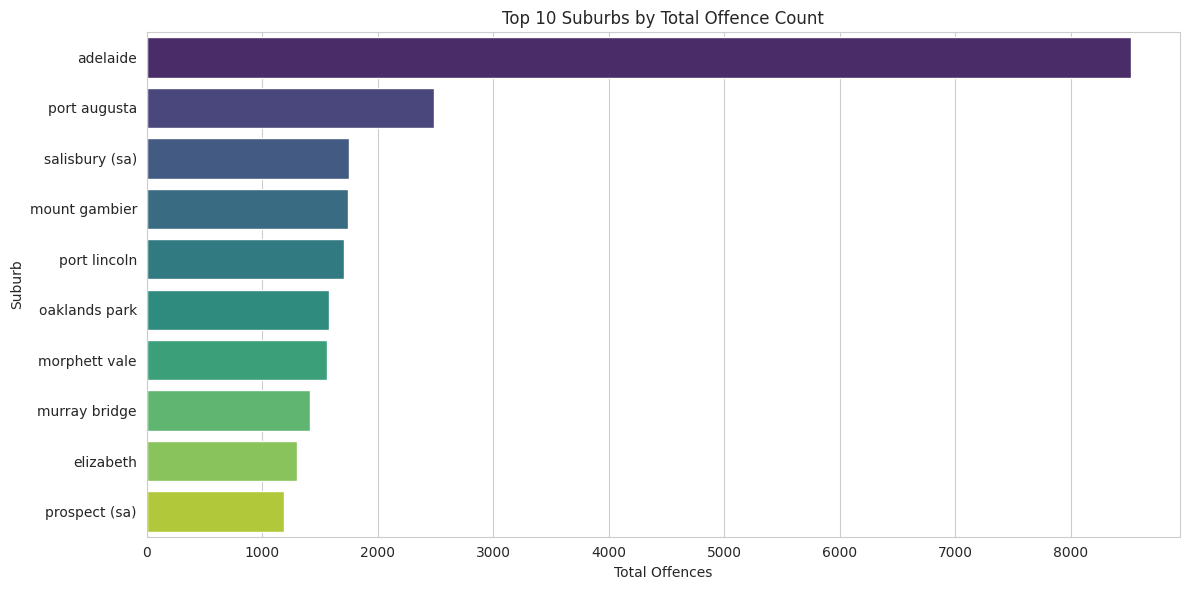

/tmp/ipython-input-451831630.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=diversity, y="Suburb", x="Distinct_Crime_Types", palette="magma_r")


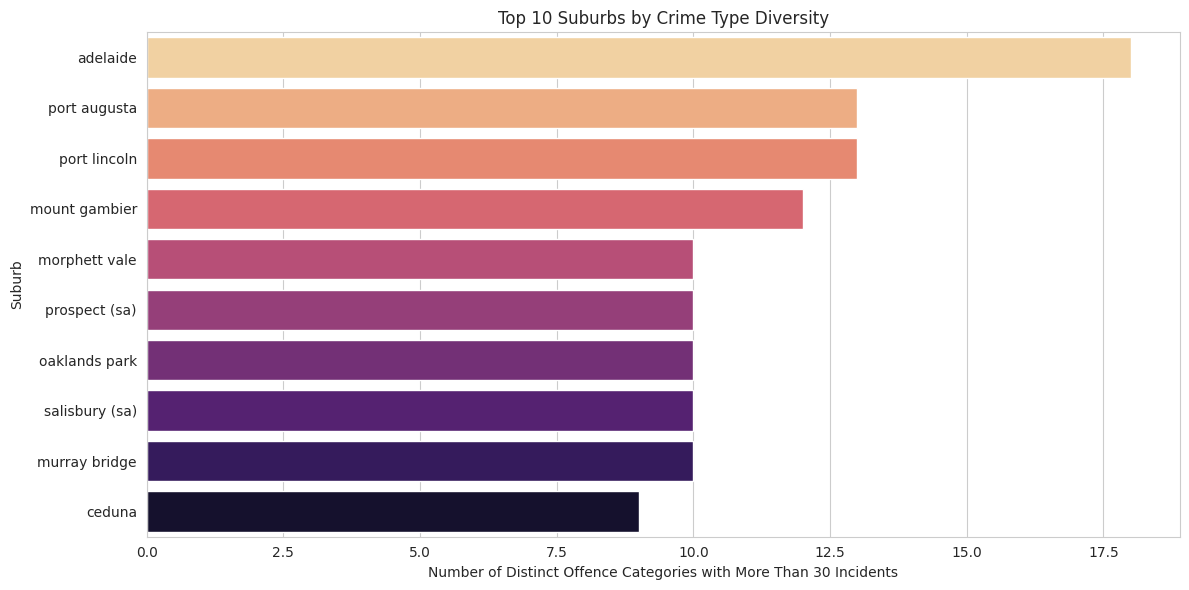

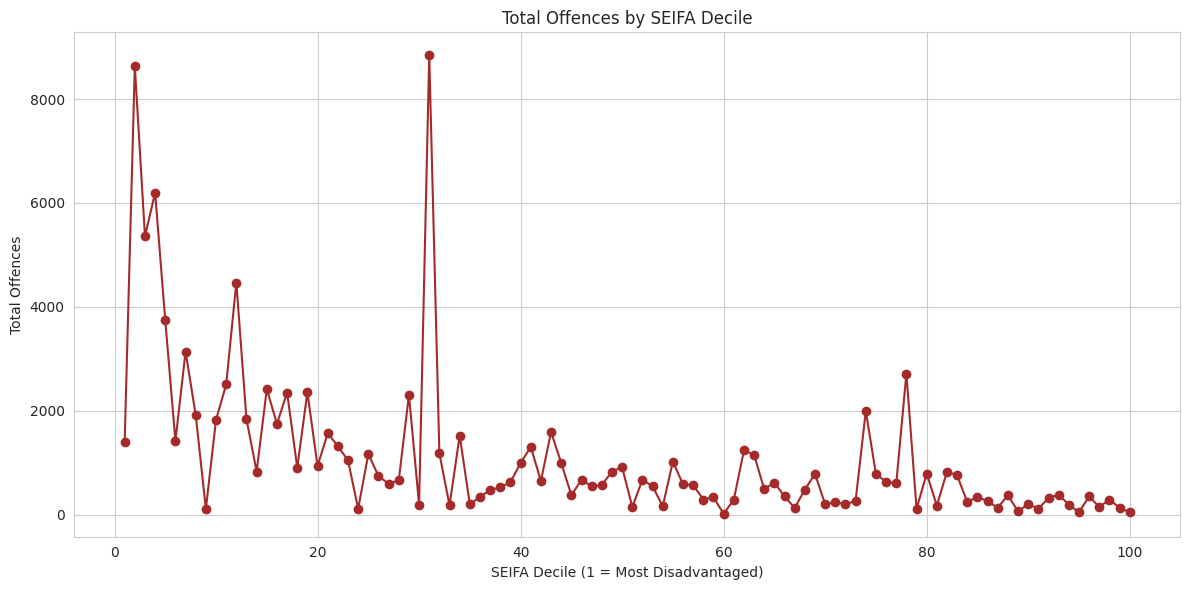

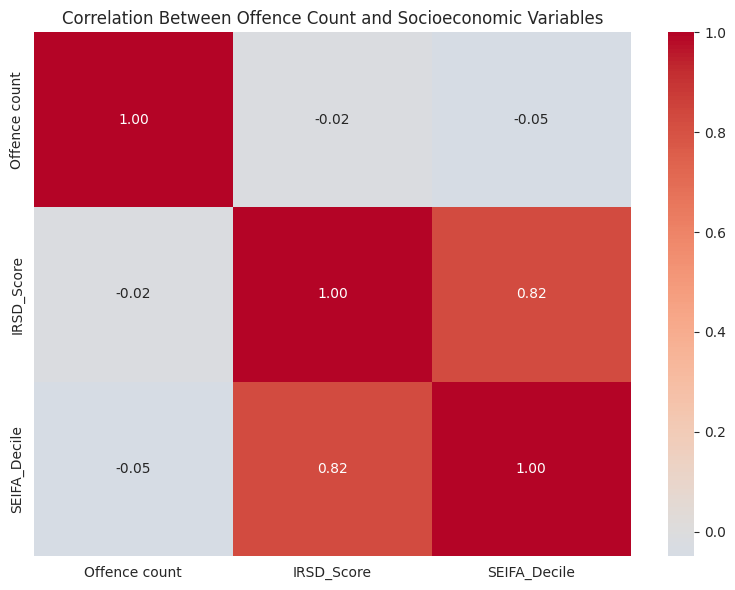

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load
df = pd.read_csv("merged_crime_seifa_sa_2023_24.csv")
df.columns = df.columns.str.strip()
df["Offence count"] = pd.to_numeric(df["Offence count"], errors="coerce").fillna(0)

# 1) Top 10 Suburbs by Total Offence Count
top_offences = (
    df.groupby("Suburb")["Offence count"]
      .sum()
      .reset_index()
      .sort_values("Offence count", ascending=False)
      .head(10)
)
plt.figure(figsize=(12,6))
sns.barplot(data=top_offences, y="Suburb", x="Offence count", palette="viridis")
plt.title("Top 10 Suburbs by Total Offence Count")
plt.xlabel("Total Offences"); plt.ylabel("Suburb")
plt.tight_layout(); plt.show()

# 2) Top 10 Suburbs by Crime Type Diversity (Level 3, >30 incidents)
lvl3 = (
    df.groupby(["Suburb", "Offence Level 3 Description"])["Offence count"]
      .sum()
      .reset_index()
)
lvl3 = lvl3[lvl3["Offence count"] > 30]
diversity = (
    lvl3.groupby("Suburb")["Offence Level 3 Description"]
        .nunique()
        .reset_index(name="Distinct_Crime_Types")
        .sort_values("Distinct_Crime_Types", ascending=False)
        .head(10)
)
plt.figure(figsize=(12,6))
sns.barplot(data=diversity, y="Suburb", x="Distinct_Crime_Types", palette="magma_r")
plt.title("Top 10 Suburbs by Crime Type Diversity")
plt.xlabel("Number of Distinct Offence Categories with More Than 30 Incidents"); plt.ylabel("Suburb")
plt.tight_layout(); plt.show()

# 3) Total Offences by SEIFA Decile
seifa_group = df.groupby("SEIFA_Decile", as_index=False)["Offence count"].sum().sort_values("SEIFA_Decile")
plt.figure(figsize=(12,6))
sns.set_style("whitegrid")
plt.plot(seifa_group["SEIFA_Decile"], seifa_group["Offence count"], marker="o", color="brown")
plt.title("Total Offences by SEIFA Decile")
plt.xlabel("SEIFA Decile (1 = Most Disadvantaged)"); plt.ylabel("Total Offences")
plt.tight_layout(); plt.show()

# 4) Correlation Heatmap (Offence count, IRSD_Score, SEIFA_Decile)
corr = df[["Offence count", "IRSD_Score", "SEIFA_Decile"]].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0, fmt=".2f")
plt.title("Correlation Between Offence Count and Socioeconomic Variables")
plt.tight_layout(); plt.show()


In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, f1_score

df = pd.read_csv('merged_crime_seifa_sa_2023_24.csv')

df = df.rename(columns={
    'Offence Level 3 Description': 'Offence_Type',
    'Offence count': 'Offence_Count'
})

# Aggregate offence types per suburb
pivot_df = df.pivot_table(
    index='Suburb',
    columns='Offence_Type',
    values='Offence_Count',
    aggfunc='sum',
    fill_value=0
)

# Add socioeconomic indicators
seifa = df.groupby('Suburb')[['IRSD_Score', 'SEIFA_Decile']].first()
combined_df = pd.concat([pivot_df, seifa], axis=1)
combined_df['Total_Offences'] = pivot_df.sum(axis=1)

# Ridge Regression
X_ridge = combined_df.drop(columns=['Total_Offences'])
y_ridge = combined_df['Total_Offences']

X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_ridge, y_ridge, test_size=0.2, random_state=42)
scaler_r = StandardScaler()
X_train_r_scaled = scaler_r.fit_transform(X_train_r)
X_test_r_scaled = scaler_r.transform(X_test_r)

ridge = Ridge()
params_ridge = {'alpha': [0.1, 1.0, 10.0]}
grid_ridge = GridSearchCV(ridge, params_ridge, cv=5)
grid_ridge.fit(X_train_r_scaled, y_train_r)
y_pred_ridge = grid_ridge.predict(X_test_r_scaled)

print("\n--- Ridge Regression ---")
print(f"Best alpha: {grid_ridge.best_params_['alpha']}")
print(f"MAE : {mean_absolute_error(y_test_r, y_pred_ridge):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test_r, y_pred_ridge)):.2f}")
print(f"R²  : {r2_score(y_test_r, y_pred_ridge):.3f}")

ridge_results = pd.DataFrame({
    'Suburb': X_test_r.index,
    'Predicted_Offences': y_pred_ridge,
    'Actual_Offences': y_test_r.values
})
ridge_results = ridge_results.sort_values(by='Predicted_Offences', ascending=False)

# Logistic Regression
threshold = combined_df['Total_Offences'].median()
combined_df['High_Crime'] = (combined_df['Total_Offences'] > threshold).astype(int)

X_log = combined_df.drop(columns=['Total_Offences', 'High_Crime'])
y_log = combined_df['High_Crime']

X_train_l, X_test_l, y_train_l, y_test_l = train_test_split(X_log, y_log, test_size=0.2, random_state=42)
scaler_l = StandardScaler()
X_train_l_scaled = scaler_l.fit_transform(X_train_l)
X_test_l_scaled = scaler_l.transform(X_test_l)

logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_l_scaled, y_train_l)
y_pred_log = logreg.predict(X_test_l_scaled)

print("\n--- Logistic Regression ---")
print(f"Accuracy: {accuracy_score(y_test_l, y_pred_log):.2f}")
print(f"F1 Score: {f1_score(y_test_l, y_pred_log):.2f}")

log_results = pd.DataFrame({
    'Suburb': X_test_l.index,
    'Predicted_High_Crime': y_pred_log,
    'Actual_High_Crime': y_test_l.values
})
log_results = log_results.sort_values(by='Predicted_High_Crime', ascending=False)

ridge_results.to_csv("ridge_predictions_by_suburb.csv", index=False)
log_results.to_csv("logistic_predictions_by_suburb.csv", index=False)



--- Ridge Regression ---
Best alpha: 0.1
MAE : 0.02
RMSE: 0.10
R²  : 1.000

--- Logistic Regression ---
Accuracy: 0.94
F1 Score: 0.95


/tmp/ipython-input-130529892.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics, y=values, palette='Purples_r')


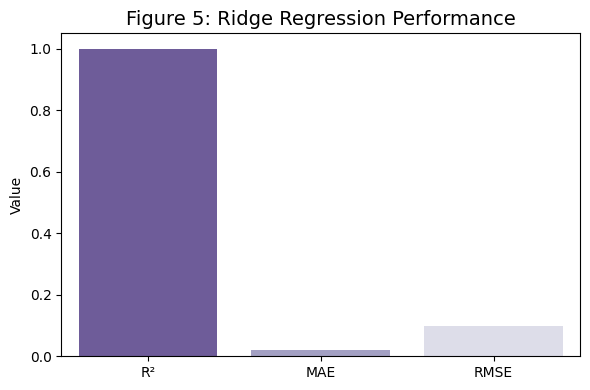

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assume these values come from your model evaluation
ridge_mae = 0.02
ridge_rmse = 0.10
ridge_r2 = 1.000

# Plot
metrics = ['R²', 'MAE', 'RMSE']
values = [ridge_r2, ridge_mae, ridge_rmse]

plt.figure(figsize=(6, 4))
sns.barplot(x=metrics, y=values, palette='Purples_r')
plt.ylim(0, 1.05)
plt.title('Figure 5: Ridge Regression Performance', fontsize=14)
plt.ylabel('Value')
plt.tight_layout()
plt.show()
